In [1]:
from datetime import timedelta
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier

import calendar
import datetime as dt
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

sns.set()

## Part 1

In [2]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.set_index('login_time', inplace = True)
logins_df['count'] = 1
logins_15T = logins_df.resample('15T').sum()
logins_15T.tail()

,count
login_time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


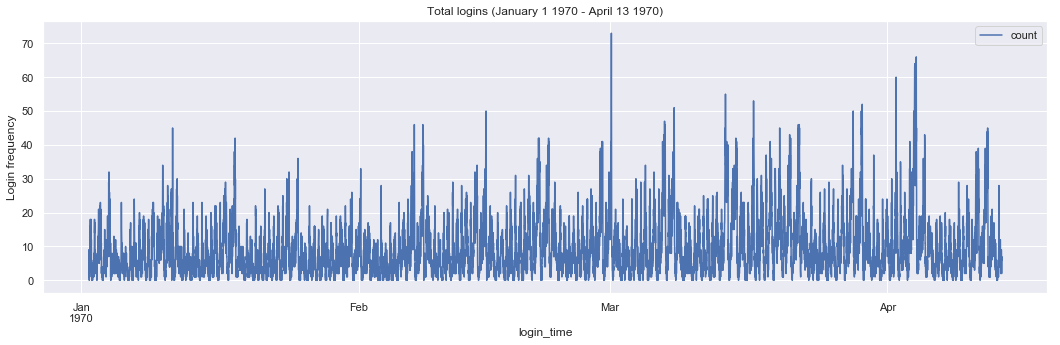

In [4]:
logins_15T.plot(y = 'count', figsize = (18,5))

plt.ylabel('Login frequency')
plt.title('Total logins (January 1 1970 - April 13 1970)')
plt.show()

Not much can be seen here by plotting the entire time series. Let's separate by month.

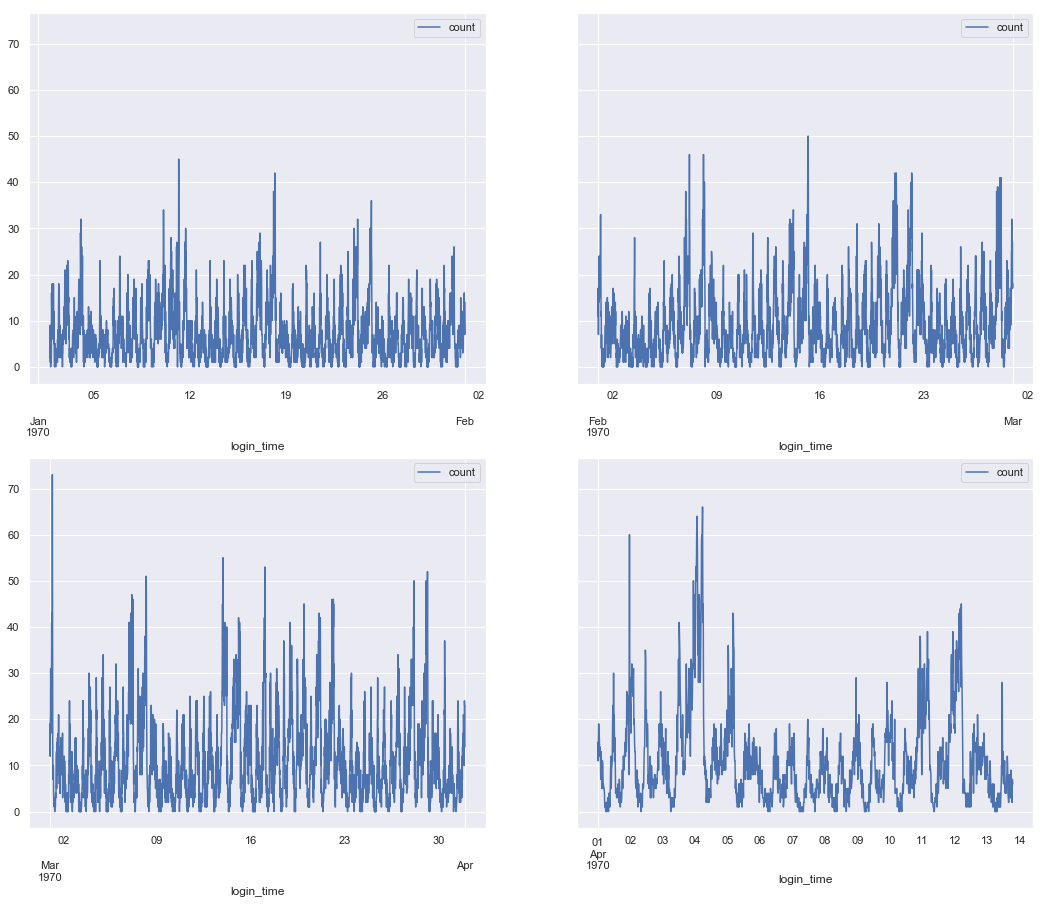

In [5]:
fig, ax = plt.subplots(2, 2, sharey = True, figsize = (18, 15))

january = logins_15T['1970-01']
february = logins_15T['1970-02']
march = logins_15T['1970-03']
april = logins_15T['1970-04']

january.plot(y = 'count', ax = ax[0, 0])
february.plot(y = 'count', ax = ax[0, 1])
march.plot(y = 'count', ax = ax[1, 0])
april.plot(y = 'count', ax = ax[1, 1])
plt.show()

The graphs look relatively similar, but login frequencies in March and April seem to have gone up on a few days.

In [6]:
january.describe()

,count
count,2896.000000
mean,7.333909
std,6.099863
min,0.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,45.000000


In [7]:
february.describe()

,count
count,2688.000000
mean,9.178943
std,7.796656
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,50.000000


In [8]:
march.describe()

,count
count,2976.000000
mean,11.331653
std,9.335820
min,0.000000
25%,4.000000
50%,9.000000
75%,16.000000
max,73.000000


In [9]:
april.describe()

,count
count,1228.000000
mean,10.999186
std,9.969840
min,0.000000
25%,4.000000
50%,8.000000
75%,15.000000
max,66.000000


Looking at a few statistics for each month, it does seem that the login frequencies are higher in March and April than January and February.

In [10]:
# ---------------------------------------
# AGGREGATE BY DAY AND ADD DAY OF WEEK  |
# --------------------------------------

logins_daily = logins_df.resample('D').sum()
logins_daily = logins_daily.reset_index()
logins_daily['DoW'] = logins_daily['login_time'].dt.day_name()

logins_daily.head()

,login_time,count,DoW
0,1970-01-01,112,Thursday
1,1970-01-02,681,Friday
2,1970-01-03,793,Saturday
3,1970-01-04,788,Sunday
4,1970-01-05,459,Monday


In [11]:
# ----------------------------------------------
# LOOKING AT LOGIN FREQUENCIES BY DAY OF WEEK  |
# ---------------------------------------------

WEEK_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

logins_dow = logins_daily.groupby('DoW')['count'].sum().reindex(WEEK_ORDER).reset_index()
logins_dow

,DoW,count
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339
3,Thursday,11960
4,Friday,15208
5,Saturday,19377
6,Sunday,18167


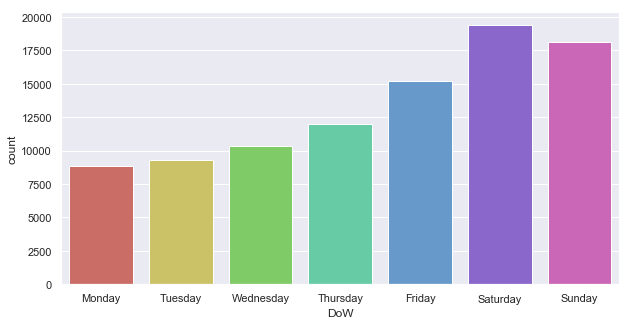

In [12]:
# ----------------------------------------
# PLOT LOGIN FREQUENCIES BY DAY OF WEEK  |
# ---------------------------------------

fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'DoW', y = 'count', data = logins_dow, palette = 'hls')

It is pretty evident that login frequencies increase as the week goes on. We see the most logins during the weekends.

In [13]:
logins_15T = logins_15T.reset_index()

In [14]:
# ----------------------------------------------
# LOOKING AT LOGIN FREQUENCIES BY TIME OF DAY  |
# ---------------------------------------------

logins_15T['time'] = logins_15T['login_time'].dt.time


# -----------------------------------------------------
# CREATING 'time_of_day' & ADDING DAY OF WEEK COLUMN  |
# ----------------------------------------------------

EARLY_MORNING = dt.time(5, 59)
MORNING = dt.time(11, 59)
AFTERNOON = dt.time(17, 59)
EVENING = dt.time(23, 59)

logins_15T.loc[logins_15T['time'] <= EARLY_MORNING, 'time_of_day'] = 'Early morning'
logins_15T.loc[(logins_15T['time'] > EARLY_MORNING) & \
               (logins_15T['time'] <= MORNING), 'time_of_day'] = 'Morning'
logins_15T.loc[(logins_15T['time'] > MORNING) & \
               (logins_15T['time'] <= AFTERNOON), 'time_of_day'] = 'Afternoon'
logins_15T.loc[(logins_15T['time'] > AFTERNOON) & \
               (logins_15T['time'] <= EVENING), 'time_of_day'] = 'Evening'

logins_15T['DoW'] = logins_15T['login_time'].dt.day_name()

logins_15T.head()

,login_time,count,time,time_of_day,DoW
0,1970-01-01 20:00:00,2,20:00:00,Evening,Thursday
1,1970-01-01 20:15:00,6,20:15:00,Evening,Thursday
2,1970-01-01 20:30:00,9,20:30:00,Evening,Thursday
3,1970-01-01 20:45:00,7,20:45:00,Evening,Thursday
4,1970-01-01 21:00:00,1,21:00:00,Evening,Thursday


In [15]:
logins_15T.groupby('time_of_day')['count'].sum().reset_index()

,time_of_day,count
0,Afternoon,20455
1,Early morning,30920
2,Evening,28606
3,Morning,13161


From the grouping above, users log in most often during the evening and early morning.

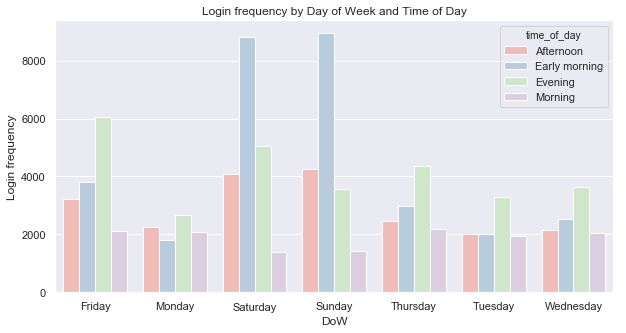

In [16]:
# ------------------------------------------------------------
# PLOTTING LOGIN FREQUENCIES BY DAY OF WEEK AND TIME OF DAY  |
# -----------------------------------------------------------

tod = logins_15T.groupby(['DoW', 'time_of_day'])['count'].sum().reset_index()

fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'DoW', y = 'count', hue = 'time_of_day', data = tod, palette = 'Pastel1')
plt.ylabel('Login frequency')
plt.title('Login frequency by Day of Week and Time of Day')
plt.show()

- Login frequencies are extremely high early mornings during the weekends
- On the weekdays, login frequencies are highest during the evenings
- Users don't tend to log in as often in the mornings

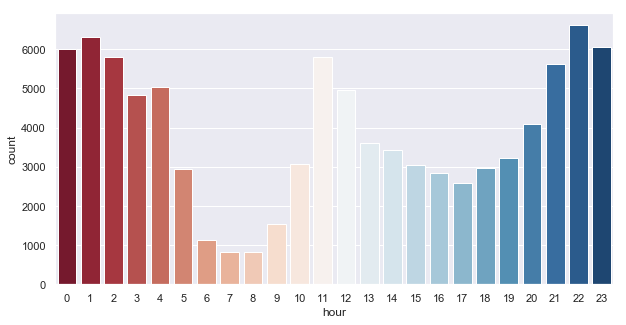

In [17]:
# ------------------------------------
# PLOTTING HOURLY LOGIN FREQUENCIES  |
# -----------------------------------

logins_15T['hour'] = logins_15T['login_time'].dt.hour
logins_hr = logins_15T.groupby('hour')['count'].sum().reset_index()

fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(x = 'hour', y = 'count', data = logins_hr, palette = 'RdBu')

Counting login frequencies by the hour, we can see that login frequencies are high from 11am-12pm and 9pm-4am.

## Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

> I believe the key measure of success would be the number of times the driver crosses the toll bridge. This would indicate that the drivers are more inclined to be available in both cities. Another alternative that is similar is to gather the total number of jobs each driver picks up, taking note of the jobs that were picked up in each city. Compare these numbers to the ones from before the incentive was offered to get an idea if the idea is effective or not.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

 - a.) How you will implement the experiment

> A good way to implement the experiment is to gather data on the pick up and drop off locations, and whether or not during the trip the driver crossed the toll bridge at all. Gather enough data before announcing the incentive, then continue gathering data once the experiment is in progress. Having these data available will allow us to test the effectiveness of the incentive.

 - b.) What statistical test(s) you will conduct to verify the significance of the observation

> I would conduct a t-test and set the null hypothesis to be "The incentive has no effect on encouraging drivers to be available in both locations." Setting the significance level to be 0.05 and using the data collected, compare the average of trips that require crossing the toll bridge before and after the incentive.

 - c.) How you would interpret the results and provide recommendations to the city operations team along with any caveats.

> Since the null hypothesis assumes the incentive does not encourage drivers to be available in both cities, the average trips taken across the toll bridge before and after the incentive was announced should not have a huge difference. If the actual difference observed (based on the data gathered) is considered significant, then the null hypothesis is rejected and we can conclude that the incentive is effective.

## Part 3

In [18]:
with open('ultimate_data_challenge.json') as f:
    json = json.load(f)

df = pd.DataFrame(json)

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data cleaning

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


"avg_rating_by_driver", "avg_rating_of_driver", and "phone" contain some **missing values**

In [20]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

In [21]:
# -------------------------
# FILL IN MISSING VALUES  |
# ------------------------

df.fillna(df.mean(), inplace = True)
df['phone'] = df['phone'].fillna('iPhone')

# ----------------------------------------------------
# CONVERT 'last_trip_date' & 'signup_date' TO DATES  |
# ---------------------------------------------------

df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

### Create target variable

In [22]:
last_date = df['last_trip_date'].max()
cutoff = last_date - timedelta(30)

df.loc[df['last_trip_date'] > cutoff, 'status'] = 'Active'
df.loc[df['last_trip_date'] <= cutoff, 'status'] = 'Inactive'

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,status
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,Active
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,Inactive
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,Inactive
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,Active
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,Inactive


### Exploratory data analysis

In [23]:
total = len(df)
retained = len(df[df['status'] == 1])

fraction_retained = retained/total

print('Percentage of retained users:', fraction_retained)

Percentage of retained users: 0.0


Of the entire dataset, only 36.62% of the users are still active users. This is an indication of class imbalance.

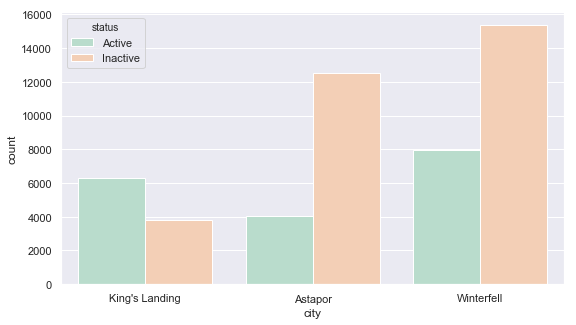

PROPORTION OF ACTIVE USERS BY CITY
----------------------------------
King's Landing: 0.6226061204343534
Astapor: 0.24325632030966493
Winterfell: 0.34200377099760026


In [24]:
fig, ax = plt.subplots(figsize = (9, 5))
sns.countplot(x = 'city', hue = 'status', data = df, ax = ax, palette = 'Pastel2')
plt.show()

df['city'].value_counts()# == "King's Landing"
kings = df[df['city'] == "King's Landing"]
astapor = df[df['city'] == 'Astapor']
winterfell = df[df['city'] == 'Winterfell']

print('PROPORTION OF ACTIVE USERS BY CITY')
print('----------------------------------')
print("King's Landing:", len(kings[kings['status'] == 'Active']) / len(kings))
print('Astapor:', len(astapor[astapor['status'] == 'Active']) / len(astapor))
print('Winterfell:', len(winterfell[winterfell['status'] == 'Active']) / len(winterfell))

A lot of users seem to be from Winterfell. Coming in second place is Astapor, and last is King's Landing. However, the percentage of retained users is highest in King's Landing, lowest in Astapor.

In [25]:
active = df[df['status'] == 'Active']
inactive = df[df['status'] == 'Inactive']

print('ACTIVE USERS')
print('------------')
print('Average distance (in miles) per trip taken in the first 30 days after signup:', round(active['avg_dist'].mean(), 2), '\n')

print('INACTIVE USERS')
print('--------------')
print('Average distance (in miles) per trip taken in the first 30 days after signup:', round(inactive['avg_dist'].mean(), 2))

ACTIVE USERS
------------
Average distance (in miles) per trip taken in the first 30 days after signup: 5.12 

INACTIVE USERS
--------------
Average distance (in miles) per trip taken in the first 30 days after signup: 6.19


It seems that inactive users took longer trips (on average) during their first 30 days after signup than active users.

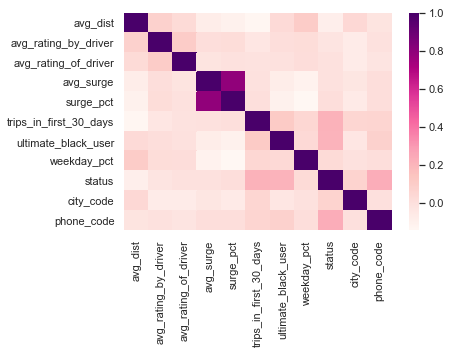

In [26]:
df['city'] = pd.Categorical(df['city'])
df['city_code'] = df['city'].cat.codes
df['phone'] = pd.Categorical(df['phone'])
df['phone_code'] = df['phone'].cat.codes
df['status'] = df['status'].map({'Active': 1, 'Inactive': 0})

sns.heatmap(df.corr(), cmap = 'RdPu')

Based on the heatmap above, it seems that the variables most correlated to 'status' are:
- 'ultimate_black_user'
- 'trips_in_first_30_days'
- 'phone'

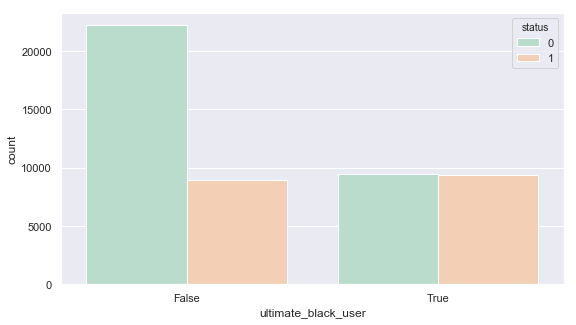

In [27]:
fig, ax = plt.subplots(figsize = (9, 5))
sns.countplot(x = 'ultimate_black_user', hue = 'status', data = df, ax = ax, palette = 'Pastel2')

A lot of the users who are not Ultimate Black Users do not stay. About half of those who are Ultimate Black Users stay active.

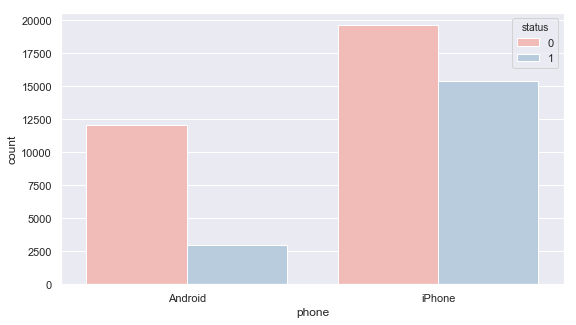

In [28]:
fig, ax = plt.subplots(figsize = (9, 5))
sns.countplot(x = 'phone', hue = 'status', data = df, ax = ax, palette = 'Pastel1')

First off, there are a lot more iPhone users than there are Android users. Of the Android users, very little of them stayed active. Of all the iPhone users, there are also more inactive users than there are active users, but the proportion is not as extreme as the Android users.

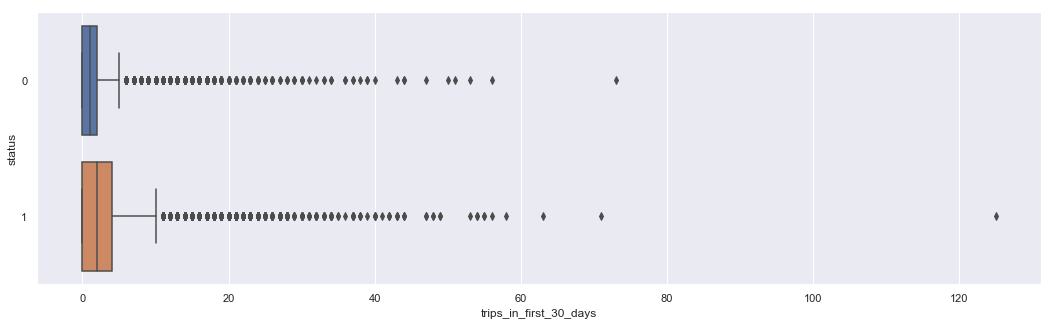

In [29]:
fig, ax = plt.subplots(figsize = (18, 5))
sns.boxplot(x = 'trips_in_first_30_days', y = 'status', ax = ax, data = df, orient = 'h')

Those who remained as active users generally took slightly more trips in their first 30 days of signup than the inactive users.

### Predictive model

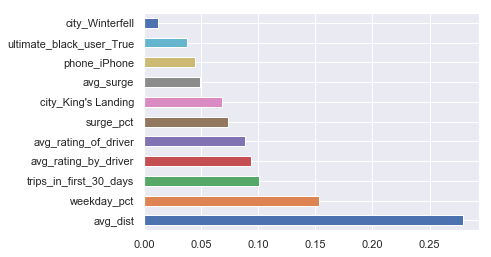

In [30]:
test = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first = True)
test = test.drop(['city_code', 'phone_code', 'last_trip_date', 'signup_date'], axis = 1)

X = test.drop('status', axis = 1)
y = test['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


# ---------------------
# FEATURE IMPORTANCE  |
# --------------------

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
feature_importances = pd.Series(etc.feature_importances_, index = X.columns)
feature_importances.nlargest(11).plot(kind = 'barh')

In [31]:
# -------------------------------------------------
# TUNING HYPERPARAMETERS FOR LOGISTIC REGRESSION  |
# ------------------------------------------------

lr = LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C = C, penalty = penalty)

clf = GridSearchCV(lr, hyperparameters, cv = 5, verbose = 0)
best_model = clf.fit(X_train, y_train)

print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best penalty: l1
Best C: 2.7825594022071245


In [32]:
# ---------------------------
# RANDOM FOREST CLASSIFIER  |
# --------------------------

rfc = RandomForestClassifier(n_estimators = 100, max_depth = 10, class_weight = 'balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('RANDOM FOREST CLASSIFIER')
print('------------------------')
print(classification_report(y_test, y_pred))

# ---------------------------------
# K-NEAREST NEIGHBORS CLASSIFIER  |
# --------------------------------

knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('K-NEAREST NEIGHBORS')
print('-------------------')
print(classification_report(y_test, y_pred))

# ----------------------
# LOGISTIC REGRESSION  |
# ---------------------

lr = LogisticRegression(penalty = 'l1', C = 7.7, class_weight = 'balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('LOGISTIC REGRESSION')
print('-------------------')
print(classification_report(y_test, y_pred))

RANDOM FOREST CLASSIFIER
------------------------
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6322
           1       0.68      0.75      0.71      3678

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.76      0.77      0.77     10000
weighted avg       0.79      0.78      0.78     10000

K-NEAREST NEIGHBORS
-------------------
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      6322
           1       0.67      0.62      0.65      3678

   micro avg       0.75      0.75      0.75     10000
   macro avg       0.73      0.72      0.73     10000
weighted avg       0.75      0.75      0.75     10000

LOGISTIC REGRESSION
-------------------
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      6322
           1       0.58      0.68      0.63      3678

   micro avg       0.70      0.70      0.70     1000

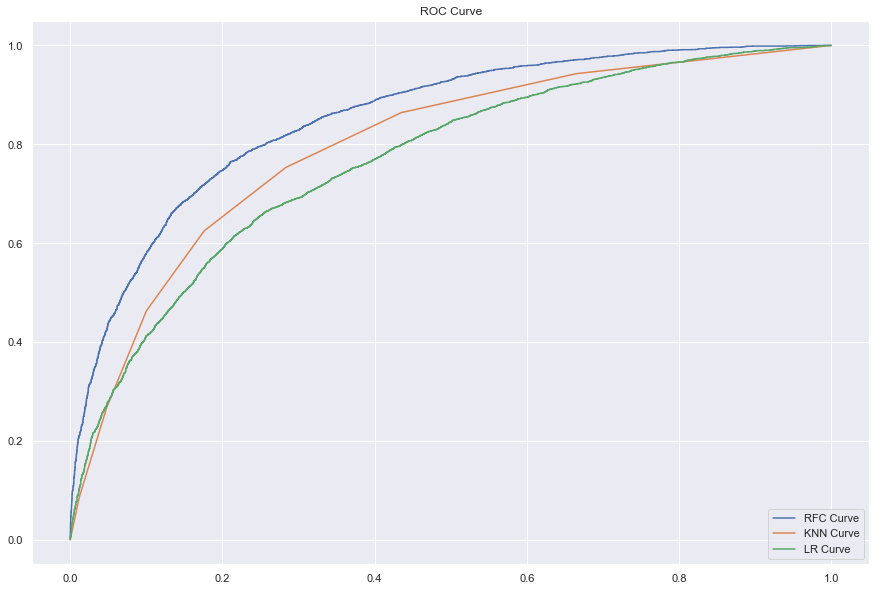

In [33]:
rfc_y_pred_prob = rfc.predict_proba(X_test)[:,1]
knn_y_pred_prob = knn.predict_proba(X_test)[:,1]
lr_y_pred_prob = lr.predict_proba(X_test)[:,1]

rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, rfc_y_pred_prob)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_y_pred_prob)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_y_pred_prob)

fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(rfc_fpr, rfc_tpr, label = 'RFC Curve')
plt.plot(knn_fpr, knn_tpr, label = 'KNN Curve')
plt.plot(lr_fpr, lr_tpr, label = 'LR Curve')

plt.legend(loc = 'lower right')
plt.title('ROC Curve')
plt.show()

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

> 36.67% of the observed users were retained

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

> I chose the Random Forest Classifier, K-nearest Neighbors Classifier, and Logistic Regression. 

> Random forest classifiers are great in that the risk of overfitting is reduced due to the repetitive random subsetting. This allows for a better model. 

> K-nearest neighbors were chosen as an alternative because based on the EDA, factors such as location, phone type, number of trips 30 days since signing up, and whether or not the user is/was a Ultimate Black user were somewhat important features. A user matching one or more of the above descriptions are probably more likely to stay active, just like how data points are classified based on the majoity of its neighbors.

> Lastly, a logistic regressor is simple and can reduce feature coefficients to 0 (if using Lasso regression, which is what this logistic regression model uses). The dataset that was prepared for training the models had quite a few features, so having feature selection is helpful.

> For all models, the hyperparameters were tuned. Based on the classification report, the random forest classifier has the best performance. Looking at its F1 score, it has the highest among the three classifiers.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

> It seems that users in King's Landing have some kind of significance in determining retention, and so do other properties like phone type (iPhones, specifically), whether they also become an Ultimate Black user, and the number of trips taken during the first 30 days of signup. More data will be required to analyze what causes users to become an Ultimate Black user and/or take more trips during the first month of signup, but Ultimate can take a look into why uses who sign up from King's Landing are likely to remain active users. Ultimate should also take a look into their apps for iPhones and Androids. There may be a discrepancy in app performance that is causing Android users to avoid using Ultimate.